## Start by importing the linear model and check the RMSLE:

In [86]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

lm = LinearRegression()

plt.style.use('ggplot')
%matplotlib inline


#Load our two Data Frames
AmesDummiesOrdinalF = pd.read_csv('AmesDummiesOrdinalF.csv', index_col=0)

In [87]:
OriginalList = list(AmesDummiesOrdinalF.columns).remove('SalePrice')

In [88]:
#Trim AmesDummiesOrdinal to a DF containing only the selected Features:
AmesDF = AmesDummiesOrdinalF.copy()

In [89]:
#Transform AmesDF into the Train AmesDF
np.random.seed(19)
testIdxes = np.random.choice(range(1458), size=292, replace=False)

trainIdxes = list(set(range(1458))-set(testIdxes))

AmesDF2 = AmesDF.copy()
AmesDF = AmesDF.iloc[trainIdxes,]
AmesDFTest = AmesDF2.iloc[testIdxes,]

In [90]:
#Reindex the AmesDF:
AmesDF.index = range(1166)


In [91]:
#Ridge regression

from sklearn.linear_model import Ridge 
from sklearn import preprocessing

ridge_df=AmesDummiesOrdinalF.copy()

SalePrice_r=ridge_df.SalePrice
ridge_df=ridge_df.drop('SalePrice',axis=1)

#Standardize all input columns to 0-1
def standize_df(df,collist):
    for col in collist:
        stan_df=df[[col]]
        min_max_scaler = preprocessing.MinMaxScaler()
        standardized=min_max_scaler.fit_transform(stan_df)
        stan2_df=pd.DataFrame(standardized,columns=stan_df.columns,index=stan_df.index)
        df[[col]]=stan2_df
    return df


collist=list(ridge_df.columns)
ridge_df=standize_df(ridge_df,collist)

#Split to 80%-20% with seed 19
np.random.seed(19)
testIdxes = np.random.choice(range(1458), size= 292, replace=False)

trainIdxes = list(set(range(1458))-set(testIdxes))
rX = ridge_df.iloc[trainIdxes]
rtestX  = ridge_df.iloc[testIdxes]
rY = SalePrice_r.iloc[trainIdxes]
rtestY  = SalePrice_r.iloc[testIdxes]

# with 10 k-fold test, the best lambda=5.129
ridge=Ridge()
ridge.set_params(alpha=5.129)
ridge.fit(rX,rY)
rtrain_score=ridge.score(rX,rY)
rtest_score= ridge.score(rtestX,rtestY)

PredictionsTest=ridge.predict(rtestX)
RMSLEvalue = np.sqrt(np.mean(np.power(np.log1p(rtestY)-np.log1p(PredictionsTest), 2)))


print ('train_score(R2)\t',rtrain_score)
print ('test_score(R2) \t',rtest_score)
print ('Ridge RMSLE \t',RMSLEvalue)

train_score(R2)	 0.8904834301682193
test_score(R2) 	 0.8984370633136243
Ridge RMSLE 	 0.13371802961456117


In [105]:
#Elasticnet

from sklearn.linear_model import ElasticNet 
from sklearn import preprocessing

net_df=AmesDummiesOrdinalF.copy()

SalePrice_e=net_df.SalePrice
net_df=net_df.drop('SalePrice',axis=1)

#Standardize all input columns to 0-1
def standize_df(df,collist):
    for col in collist:
        stan_df=df[[col]]
        min_max_scaler = preprocessing.MinMaxScaler()
        standardized=min_max_scaler.fit_transform(stan_df)
        stan2_df=pd.DataFrame(standardized,columns=stan_df.columns,index=stan_df.index)
        df[[col]]=stan2_df
    return df


collist=list(net_df.columns)
net_df=standize_df(net_df,collist)

#Split to 80%-20% with seed 19
np.random.seed(19)
testIdxes = np.random.choice(range(1458), size= 292, replace=False)

trainIdxes = list(set(range(1458))-set(testIdxes))
eX = net_df.iloc[trainIdxes]
etestX  = net_df.iloc[testIdxes]
eY = SalePrice_e.iloc[trainIdxes]
etestY  = SalePrice_e.iloc[testIdxes]

# alpha=0.01, rho=0.522
net   = ElasticNet()
net.set_params(alpha=0.01, l1_ratio=0.5220689655172415)
net.fit(eX, eY)
etrain_score=net.score(eX,eY)
etest_score=net.score(etestX,etestY)
ePredictionsTest=net.predict(etestX)
RMSLEvalue = np.sqrt(np.mean(np.power(np.log1p(etestY)-np.log1p(ePredictionsTest), 2)))


print ('train_score(R2)\t',etrain_score)
print ('test_score(R2) \t',etest_score)
print ('Elasticnet RMSLE \t',RMSLEvalue)

train_score(R2)	 0.8892670533994463
test_score(R2) 	 0.8982573209590262
Elasticnet RMSLE 	 0.13370516802339327


In [93]:
#Run Linear Regression on the Overall (80%) train set, based on earlier K-fold:

#Create X and Y variables
X = AmesDF.drop('SalePrice', axis=1)
Y = AmesDF['SalePrice']

#Rename the true (20% untouched) test DFs
testX = AmesDFTest.drop('SalePrice', axis=1)
testY = AmesDFTest['SalePrice']

#Run the linear regression and check RMSLE:
lm.fit(X, Y)
lmscore = lm.score(X, Y)
lmpredict = lm.predict(X)

#Get scores for the Test set
lmtestscore = lm.score(testX, testY)
testpredict = lm.predict(testX)

RMSLE = np.sqrt(np.mean(np.power(np.log1p(testY)-np.log1p(testpredict), 2)))

print("The train R^2 score is: " + str(lmscore))
print("The test R^2 score is: " + str(lmtestscore))
print("The test RMSLE is: " + str(RMSLE))


The train R^2 score is: 0.9061568573558394
The test R^2 score is: 0.8824331291544814
The test RMSLE is: 0.15553608966466886


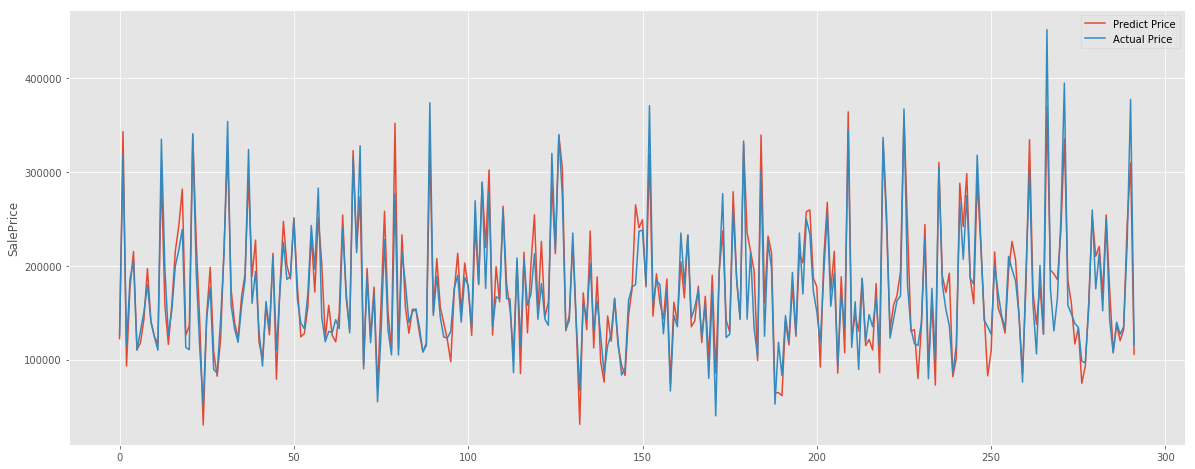

In [94]:
plt.figure(figsize=(20,8))
plt.plot(range(292),testpredict,label="Predict Price")
plt.plot(range(292),testY,label="Actual Price")
plt.legend(loc="best")
plt.ylabel("SalePrice")
plt.show()

## Now, import the Random Forest model and check the overall RMSLE:

In [95]:
#Run Random Forest on the Overall (80%) train set, based on earlier K-fold:


#Import RandomForestRegressor and set parameters to those found in the hyperparameter testing:
from sklearn import ensemble
randomForest = ensemble.RandomForestRegressor()
randomForest.set_params(bootstrap=False, max_depth=None, max_features='sqrt', min_samples_leaf=1, min_samples_split=2, 
                        n_estimators=200)

#Run the linear regression and check RMSLE:
randomForest.fit(X, Y)
rfscore = randomForest.score(X, Y)
rfpredict = randomForest.predict(X)

#Get scores for the Test set
rftestscore = randomForest.score(testX, testY)
testpredictrf = randomForest.predict(testX)

RMSLErf = np.sqrt(np.mean(np.power(np.log1p(testY)-np.log1p(testpredictrf), 2)))

print("The train R^2 score is: " + str(rfscore))
print("The test R^2 score is: " + str(rftestscore))
print("The test RMSLE is: " + str(RMSLErf))

The train R^2 score is: 0.9999964049302276
The test R^2 score is: 0.9044362228147217
The test RMSLE is: 0.13032704766402137


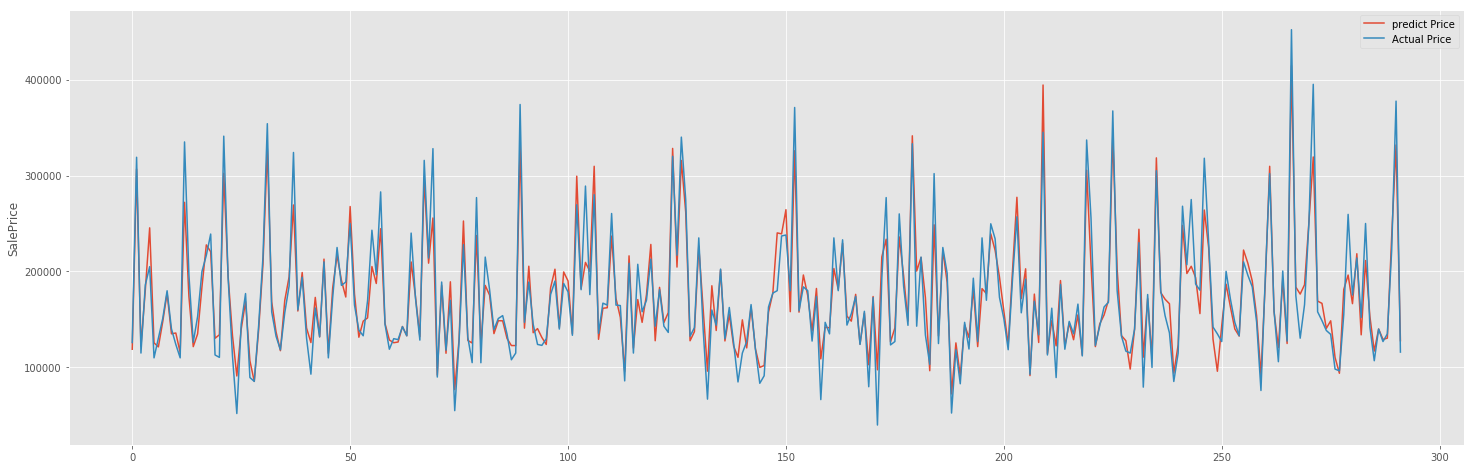

In [106]:
plt.figure(figsize=(25,8))
plt.plot(range(292),testpredictrf,label="predict Price")
plt.plot(range(292),testY,label="Actual Price")
plt.legend(loc='best')
plt.ylabel('SalePrice')
plt.show()

## Now, import the Gradient Boost model and check the overall RMSLE:

In [96]:
#Run Gradient Boost on the Overall (80%) train set, based on earlier K-fold:

#Import GradientBoostRegressor and set parameters to those found in the hyperparameter testing:
from sklearn import ensemble
gradientBoost = ensemble.GradientBoostingRegressor()
gradientBoost.set_params(n_estimators=800, min_samples_split=6, min_samples_leaf=4, max_features='log2', max_depth=2, loss='huber')

#Run the linear regression and check RMSLE:
gradientBoost.fit(X, Y)
gbscore = gradientBoost.score(X, Y)
gbpredict = gradientBoost.predict(X)

#Get scores for the Test set
gbtestscore = gradientBoost.score(testX, testY)
testpredictgb = gradientBoost.predict(testX)

RMSLEgb = np.sqrt(np.mean(np.power(np.log1p(testY)-np.log1p(testpredictgb), 2)))

print("The train R^2 score is: " + str(gbscore))
print("The test R^2 score is: " + str(gbtestscore))
print("The test RMSLE is: " + str(RMSLEgb))

The train R^2 score is: 0.9709835625877479
The test R^2 score is: 0.928297943040686
The test RMSLE is: 0.11524445505218928


## Combine (stack) these results to generate a prediction for SalePrice and see if it outperforms the gradient boosting prediction

In [97]:
stackedpredict = (gradientBoost.predict(testX)
                  + randomForest.predict(testX) 
                  +lm.predict(testX))/3
#lm.predict(testX)+ridge.predict(rtestX)+net.predict(etestX)
RMSLEstacked = np.sqrt(np.mean(np.power(np.log1p(testY)-np.log1p(stackedpredict), 2)))
print("The stacked-model RMSLE is: " + str(RMSLEstacked))

The stacked-model RMSLE is: 0.11160859554394219


In [98]:
testY

Id
419     126000
596     319000
1126    115000
212     186000
303     205000
460     110000
840     130500
263     151000
1157    179900
346     140200
1419    124000
205     110000
693     335000
1440    197000
324     126175
902     153000
1351    200000
769     216837
418     239000
240     113000
1064    110500
719     341000
81      193500
1217    112000
711      52000
255     145000
1344    177000
308      89500
977      85500
646     143250
         ...  
367     159000
810     106000
872     200500
761     127500
592     451950
430     175000
715     130500
1255    165400
1375    250000
775     395000
854     158000
688     148800
1296    138500
216     134450
647      98300
515      96500
483     155000
115     259500
1237    175500
338     214000
165     152000
860     250000
1426    142000
1207    107000
551     140000
50      127000
654     135000
733     222500
1389    377500
873     116000
Name: SalePrice, Length: 292, dtype: int64

In [99]:
ridge.predict(rtestX)

array([118724.75359893, 339801.59999122,  97709.78483575, 174525.22421695,
       221200.51570025, 128746.07200925, 112409.18259036, 155424.21552128,
       208830.5748164 , 130060.53263756, 122627.88959328, 107499.56622448,
       287750.9720818 , 156962.30935887, 118275.52929666, 143773.11503359,
       222898.25917208, 235853.14147687, 258115.83903896, 127944.84888708,
       137829.22734966, 342674.9374578 , 216087.02060401, 131363.90783071,
        55538.9692047 , 136376.01115115, 195542.89916163,  95950.57233096,
        76674.20035115, 127229.25830762, 222735.93980342, 324374.48326572,
       173905.56997254, 142956.1832403 , 132238.2973312 , 166237.07375169,
       192341.39183898, 293892.76487416, 168404.62887905, 231758.36419738,
       136674.79037379, 116740.69235457, 165573.17943707, 126632.61210647,
       219726.28814292, 121015.00687332, 175104.58614138, 246747.92800029,
       197539.02386759, 169757.82139616, 250891.11557323, 186109.69298596,
       124479.11337925, 1

In [100]:
'''GradientPct = []
LinearPct = []
BoostPct = []
RMSLE = []
for i in list(range(100)):
    if i > 98:
        continue
    Js = 100-i

    for j in list(range(Js)):
        if i + j > 99:
            continue
            
        Ks = 101-i-j

        for k in list(range(Ks)):
            if i + j + k != 100:
                continue
            GradientPct.append(i)
            LinearPct.append(k)
            BoostPct.append(j)
            
            stackedpredict = (i*gradientBoost.predict(testX) + j*randomForest.predict(testX) + k*lm.predict(testX))/100
            RMSLEstacked = np.sqrt(np.mean(np.power(np.log1p(testY)-np.log1p(stackedpredict), 2)))
            RMSLE.append(RMSLEstacked)
            #print("gradient %: " + str(i) + ", randomforest%: " + str(j) + ", linear%: " + str(k) + ": RMSLE= " + str(RMSLEstacked))'''
    

'GradientPct = []\nLinearPct = []\nBoostPct = []\nRMSLE = []\nfor i in list(range(100)):\n    if i > 98:\n        continue\n    Js = 100-i\n\n    for j in list(range(Js)):\n        if i + j > 99:\n            continue\n            \n        Ks = 101-i-j\n\n        for k in list(range(Ks)):\n            if i + j + k != 100:\n                continue\n            GradientPct.append(i)\n            LinearPct.append(k)\n            BoostPct.append(j)\n            \n            stackedpredict = (i*gradientBoost.predict(testX) + j*randomForest.predict(testX) + k*lm.predict(testX))/100\n            RMSLEstacked = np.sqrt(np.mean(np.power(np.log1p(testY)-np.log1p(stackedpredict), 2)))\n            RMSLE.append(RMSLEstacked)\n            #print("gradient %: " + str(i) + ", randomforest%: " + str(j) + ", linear%: " + str(k) + ": RMSLE= " + str(RMSLEstacked))'

In [101]:
'''Gradient = pd.Series(GradientPct)
Linear = pd.Series(LinearPct)
RandomForest = pd.Series(BoostPct)
RMSLESeries = pd.Series(RMSLE)

StackGridSearchDF = pd.DataFrame({'LinearPct':Linear, 'RForestPct':RandomForest, 'GBoostPct':Gradient, 'RMSLE':RMSLESeries})'''

"Gradient = pd.Series(GradientPct)\nLinear = pd.Series(LinearPct)\nRandomForest = pd.Series(BoostPct)\nRMSLESeries = pd.Series(RMSLE)\n\nStackGridSearchDF = pd.DataFrame({'LinearPct':Linear, 'RForestPct':RandomForest, 'GBoostPct':Gradient, 'RMSLE':RMSLESeries})"

In [102]:
#StackGridSearchDF.sort_values(by='RMSLE', axis=0, ascending=False).head()

In [103]:
#StackGridSearchDF.sort_values(by='RMSLE', axis=0).head()

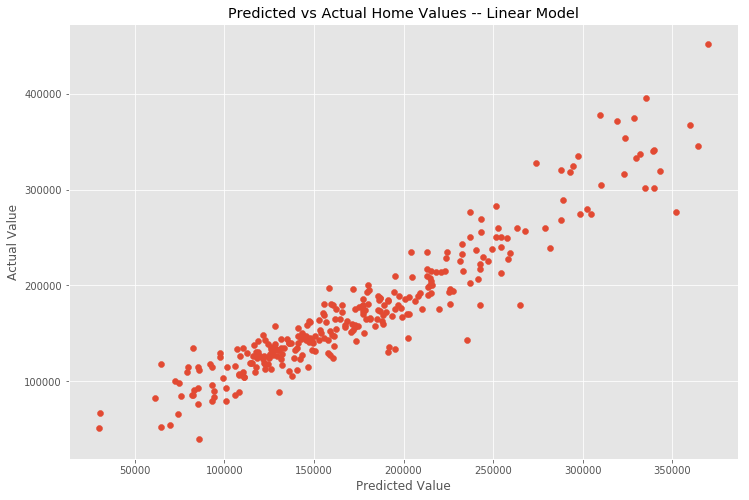

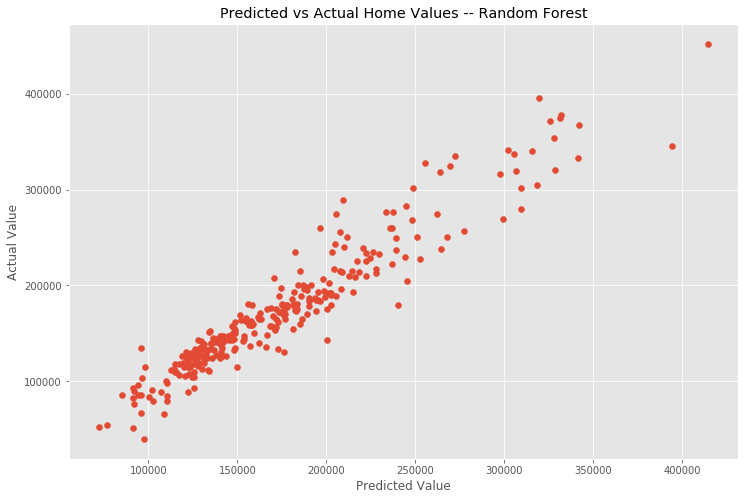

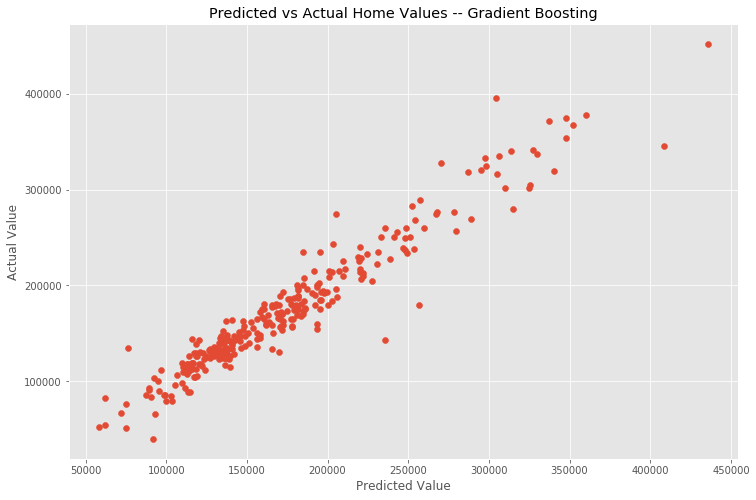

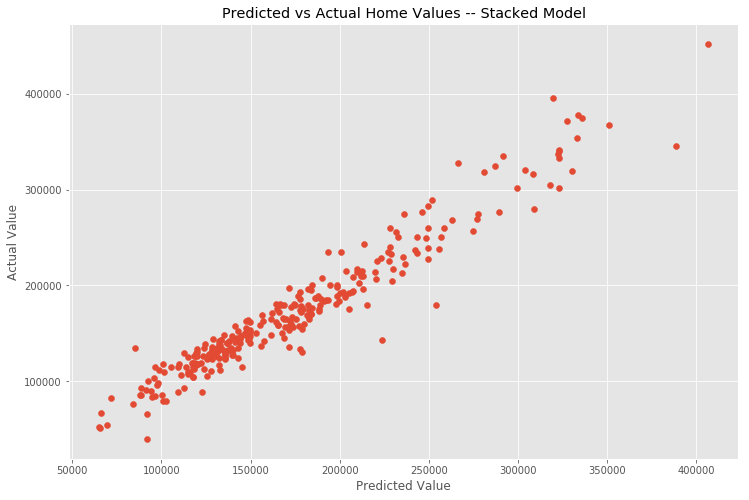

In [104]:
import matplotlib.pyplot as plt

for tup in [('Linear Model', testpredict), ('Random Forest', testpredictrf), ('Gradient Boosting', testpredictgb), ('Stacked Model', stackedpredict)]:

    plt.figure(figsize=(12,8))
    plt.scatter(tup[1], testY)
    plt.xlabel('Predicted Value')
    plt.ylabel('Actual Value')
    plt.title('Predicted vs Actual Home Values -- ' + tup[0])   
    plt.show()